# **Stroke Data ML Project**
Joshua Yaffee, George Lyu \\
INDE 577, Spring 2023

Strokes are a serious medical condition that occur when the blood supply to the brain is disrupted, either by a blood clot or a ruptured blood vessel. Strokes can cause significant disability or even death, and early detection and prevention is critical for improving patient outcomes.

Predicting strokes is important in healthcare for several reasons. First, strokes are a leading cause of death and disability worldwide, and early detection and intervention can help reduce the risk of stroke and improve patient outcomes. Second, predicting strokes can help identify patients who are at higher risk of stroke and enable healthcare providers to provide preventative measures, such as medication or lifestyle changes, to reduce that risk. Third, predicting strokes can also help healthcare providers allocate resources more efficiently, by identifying patients who are most likely to benefit from additional screening or intervention.

Common tools used to predict strokes include traditional risk assessment tools, such as the Framingham risk score, which use demographic and clinical factors to estimate a patient's risk of developing cardiovascular disease, including stroke. More recently, machine learning algorithms have been developed that can predict stroke risk using a wider range of factors, such as genetic and lifestyle factors, and can provide more personalized risk assessments.

Predicting strokes can be challenging for doctors, as the risk factors for stroke are complex and multifactorial. In addition, stroke risk can be influenced by a wide range of factors, including age, sex, lifestyle, genetics, and medical history. As a result, traditional risk assessment tools may not always provide accurate predictions, and doctors may not have access to all of the relevant information needed to make a reliable prediction. Machine learning algorithms can help address these challenges by analyzing large amounts of data and identifying patterns and risk factors associated with stroke.

##Modeling Strategy
We will employ the following analysis strategy for using machine learning to predict strokes.


1.   Evaluate dataset features
2.   Oversample the dataset
3.   Attempt several models
4.   Ensemble of models

##Dataset
We are working with the `healthcare-dataset-stroke-data.csv` dataset. It contains patient information, including categorical variable like smoking status and continuous variables like BMI. Make sure `healthcare-dataset-stroke-data.csv` is uploaded for this runtime in `Files`.

We decided to manually add the Framinghouse Risk Score (FRS) as a predictor variable by calculating this value for each patient. FRS is a predictor of risk for cardiovascular disease in the next ten years. If we had more time, we might have instead chosen to use the General Framinghouse Risk Score, which predicts a wider range of illnesses that includes specifically strokes.

In [158]:
# !pip install git+https://github.com/fonnesbeck/framingham_risk.git

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from frs import frs
import matplotlib.pyplot as plt
import plotly.express as px


In [ ]:
# Import dataset
data = pd.read_csv('https://raw.githubusercontent.com/joshyaffee/healthcare_stroke_ML/main/healthcare-dataset-stroke-data.csv', index_col="id")

# Fill in NA values. All the NA values are under the BMI column.
# We will in NA values by assigning the average BMI for the gender.
data['bmi'] = data.groupby('gender')['bmi'].apply(lambda x: x.fillna(x.mean()))

# Framingham Risk Score: Add the FRS as a feature column to the dataset
data['frs'] = [0.0] * len(data.index)
for id in data.index:
    gen = data.gender[id][0]
    if gen != "M":
        gen = "F"
    data.frs[id] = frs(gender=gen,
                        time=10, 
                        age=data.age[id], 
                        bmi=data.bmi[id],
                        sbp=120,
                        ht_treat=data.hypertension[id], 
                        smk=data.smoking_status[id] == "smoked" or data.smoking_status[id] == "formerly_smoked", 
                        dia=False)
    
# Encode categorical data
le = LabelEncoder()
data_encoded = data.copy()
for column in ('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'):
    data_encoded[column] = le.fit_transform(data[column])

# Split data into training and testing sets
X_traintest, X_validate, y_traintest, y_validate = train_test_split(data_encoded.drop('stroke', axis=1), data_encoded['stroke'], test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=46)

Let's familiarize ourselves with the (imbalanced) data. First, we visualize the distribution of the stroke observations. Then, we show the relationship between stroke and the other categorical variables. Finally, we show the relationship between stroke and the continuous variables.

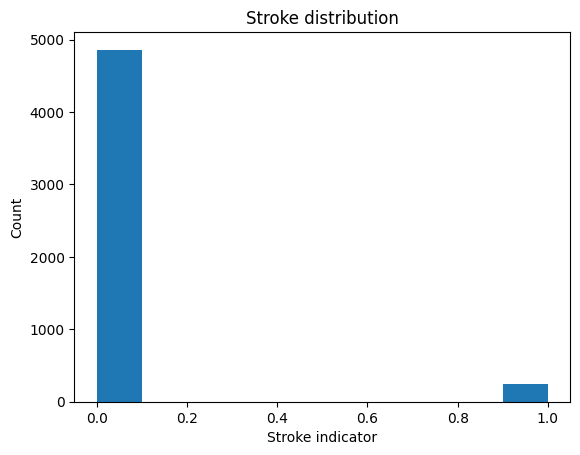

0.0487279843444227


In [160]:
plt.hist(data.stroke)
plt.xlabel("Stroke indicator")
plt.ylabel("Count")
plt.title("Stroke distribution")
plt.show()

print(np.mean(data.stroke))

In [161]:
# Show relation between stroke and categorical variables
for var in data.columns:
    if data[var].dtype != "float64":
        print(var)
        df_pivot = pd.DataFrame(np.zeros((len(data["stroke"].unique()), len(data[var].unique()))), index=range(2), columns=data[var].unique())
        for row in df_pivot.index:
            for col in df_pivot.columns:
                df_pivot.loc[row, col] = np.sum(np.multiply(data["stroke"] == row, data[var] == col)) / np.sum(data[var] == col)
        print(df_pivot)
        print()


gender
       Male    Female  Other
0  0.948936  0.952906    1.0
1  0.051064  0.047094    0.0

hypertension
          0        1
0  0.960321  0.86747
1  0.039679  0.13253

heart_disease
         1         0
0  0.82971  0.958213
1  0.17029  0.041787

ever_married
        Yes        No
0  0.934387  0.983495
1  0.065613  0.016505

work_type
   Private  Self-employed  Govt_job  children  Never_worked
0  0.94906       0.920635  0.949772  0.997089           1.0
1  0.05094       0.079365  0.050228  0.002911           0.0

Residence_type
      Urban     Rural
0  0.947997  0.954654
1  0.052003  0.045346

smoking_status
   formerly smoked  never smoked    smokes  Unknown
0         0.920904      0.952431  0.946768  0.96956
1         0.079096      0.047569  0.053232  0.03044

stroke
     1    0
0  0.0  1.0
1  1.0  0.0



From the categorical features, we see that `gender` and `Residence_type` don't substantially impact `stroke`. The `work_type` and `ever_married` do impact `stroke`, but this might be because these variables are highly correlated with the continuous `age` variable.

It appears that the most impactful categorical variables here are `hypertension`, `heart_disease`, `smoking_status`.

Let's next look at the relationship between `stroke` and the continuous variables.

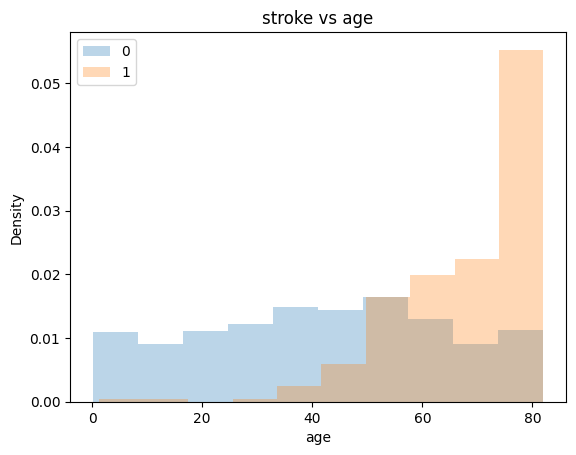

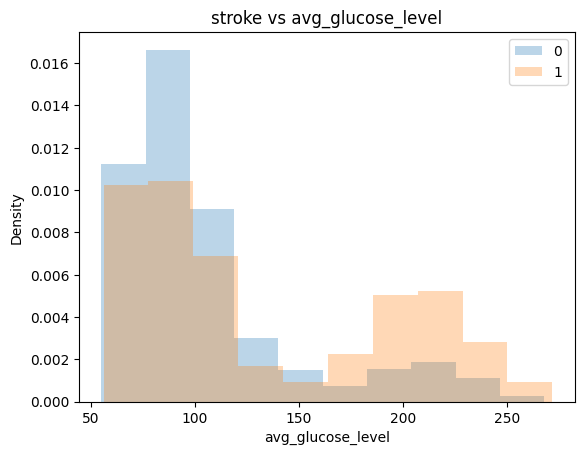

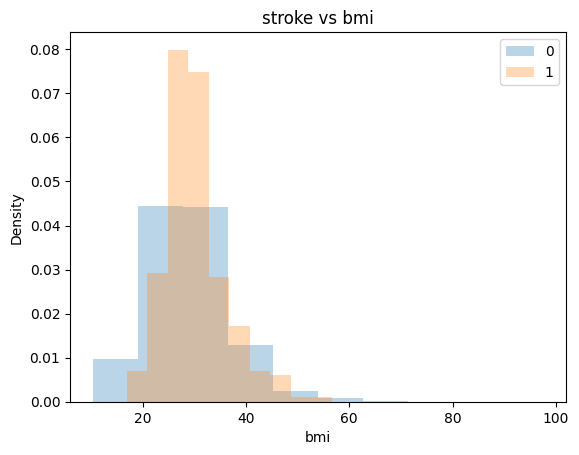

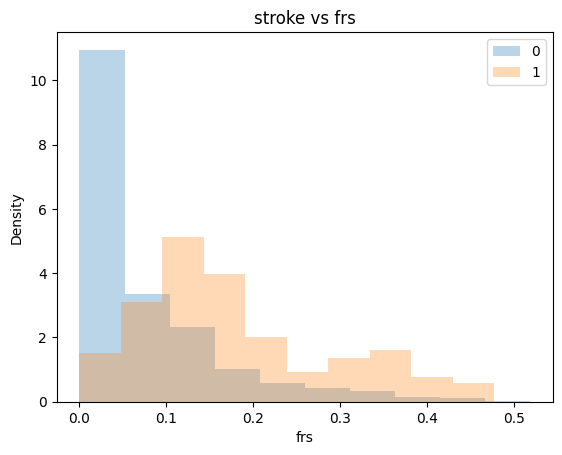

In [162]:
for var in data.columns:
    if data[var].dtype == "float64":
        for row in range(2):
            plt.hist(data[var][data["stroke"] == row], label=row, density=True, alpha=0.3)
        plt.legend()
        plt.title("stroke vs " + var)
        plt.xlabel(var)
        plt.ylabel("Density")
        plt.show()    

`age` looks to be the strongest continuous predictor of strokes. There is a clear separation where patients over 50 years old have significantly higher chance of stroke.

`frs` seems to also be a strong predictor of strokes. Patients with `frs` lower than 0.1 seem to have much lower chance of strokes.

`avg_glucose_level` seems to have a moderate correlation with strokes. Higher glucose levels relate to higher chance for stroke. Oddly, there is a bimodal distribution for the `avg_glucose_level`.

`bmi` seems to have no correlation with strokes.

##Oversampling
The dataset is extremely unbalanced. Less than 5% of the samples have a positive stroke value. From a machine-learning perspective, an ideal dataset should have an equal count of positive and negative observations.

One way to address data unbalance is via oversampling. We can use techniques like SMOTE and ADASYN to generate synthetic stroke-positive data so that we have an equal count of positive and negative observations.

##Training and Testing

###Neural Networks and Bootstrapping

Our first attempt at predicting strokes is through neural networks. We use `tensorflow` to create a dense neural network.

We use a bootstrapping approach. We generate `B` dense neural networks of the same architecture. For each model, we use a different subset of the training data. The end result is an ensemble of `B` dense neural networks.

Adjust `B` downward for speedup. Results can get unreliable as `B` gets low (below 10). `B = 20` makes for ~6 minutes of training.

In [163]:
# Define parameters
B = 35 
epochs = 20

models_stats = {}

# Create a loop to generate B Bootstrap samples
for i in range(B):
    
    #should I resample each time?(George: I think it's neat and in-line with the Bootstrapping/Bagging approach.)
    X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=46*i) # ahhhh!

    # Generate SMOTE sampled data
    sm = SMOTE(random_state=132)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    
    # Define neural network architecture
    model = keras.Sequential([
        keras.layers.Dense(6, activation='LeakyReLU', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss = 'BinaryFocalCrossentropy',
                  metrics=['binary_accuracy'])
    #                  loss= 'BinaryCrossentropy',
    # Fit model
    model.fit(X_resampled, y_resampled, epochs=epochs, verbose=0)
    
    # Evaluate model
    # Get predicted probabilities
    y_pred_prob = model.predict(X_test, verbose=0)

    # Apply threshold to get predicted classes
    y_pred = (y_pred_prob > 0.5).astype(int)
    print('model #:', i)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    p = precision_score(y_test, y_pred)
    print('Precision:', p)
    r = recall_score(y_test, y_pred)
    print('Recall:', r)
    f= f1_score(y_test, y_pred)
    print('F1 score:', f)
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

    models_stats[i] = (model, p, r, f)

model #: 0
Accuracy: 0.6939010356731876
Precision: 0.09473684210526316
Recall: 0.7714285714285715
F1 score: 0.16875000000000004
Confusion matrix:
 [[576 258]
 [  8  27]]
model #: 1
Accuracy: 0.8319907940161104
Precision: 0.12582781456953643
Recall: 0.5757575757575758
F1 score: 0.2065217391304348
Confusion matrix:
 [[704 132]
 [ 14  19]]
model #: 2
Accuracy: 0.7445339470655926
Precision: 0.11013215859030837
Recall: 0.5555555555555556
F1 score: 0.18382352941176472
Confusion matrix:
 [[622 202]
 [ 20  25]]
model #: 3
Accuracy: 0.7054085155350979
Precision: 0.06896551724137931
Recall: 0.5806451612903226
F1 score: 0.1232876712328767
Confusion matrix:
 [[595 243]
 [ 13  18]]
model #: 4
Accuracy: 0.7997698504027618
Precision: 0.13612565445026178
Recall: 0.7428571428571429
F1 score: 0.23008849557522126
Confusion matrix:
 [[669 165]
 [  9  26]]
model #: 5
Accuracy: 0.7848101265822784
Precision: 0.08900523560209424
Recall: 0.5666666666666667
F1 score: 0.15384615384615383
Confusion matrix:
 [[665

###Random Forests
An alternative to neural networks are random forests. We also attempt to use a random forest classifier to predict strokes. We also use a gradient-boosted random forest.

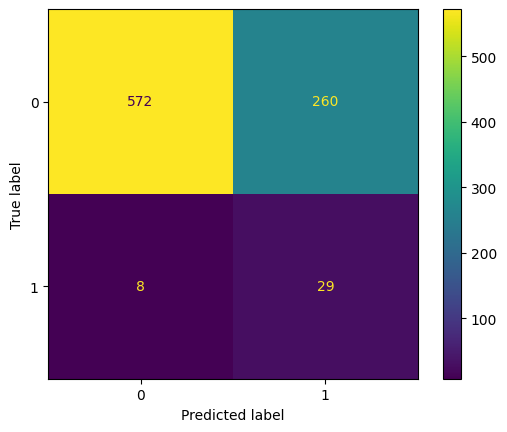

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       832
           1       0.10      0.78      0.18        37

    accuracy                           0.69       869
   macro avg       0.54      0.74      0.49       869
weighted avg       0.95      0.69      0.78       869



In [164]:
# Get data
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=21)
sm = SMOTE(random_state=132)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train random forest
rf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=1)
rf.fit(X_resampled, y_resampled)

# Predict on the test data
y_pred = rf.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test.tolist(), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()
print(metrics.classification_report(y_test.tolist(), y_pred))

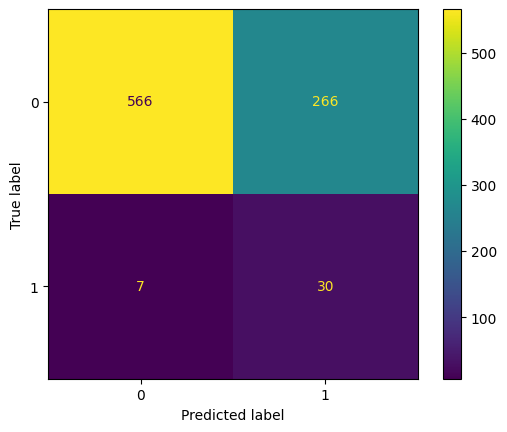

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       832
           1       0.10      0.81      0.18        37

    accuracy                           0.69       869
   macro avg       0.54      0.75      0.49       869
weighted avg       0.95      0.69      0.78       869



In [165]:
# Train gradient-boosted random forest
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=42)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

# Confusion matrix
confusion_mat = metrics.confusion_matrix(y_test.tolist(), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_mat)
cm_display.plot()
plt.show()
print(metrics.classification_report(y_test.tolist(), y_pred))


###Ensemble
We've now generated dozens of predictive models. Let's conglomerate them all into a single predictive function as an ensemble. We will input all the models' predictions as the inputs to a logistic regression model. We will treat the logisitc regression's output as our final prediction for whether a patient has a stroke or not.

I.e., given a patient's information, we will predict the patient's stroke status using each of our 37 models (35 NN and 2 random forests). Then, we will feed these 37 predictions as inputs into a logistic regression model. The logistic regression will ensemble these predictions to formulate our final prediction.

In [166]:
# Conglomerate the models
models = [val[0] for val in models_stats.values()]
models.append(clf)
models.append(rf)

# min_precision = .11 
# min_recall = .6 
# min_f1 = .2 

#models = [val[0] for val in models_stats.values() if val[1] >= min_precision and val[2] >= min_recall and val[3] >= min_f1]
# models = [val[0] for val in models_stats.values() if val[1] >= min_precision or val[2] >= min_recall or val[3] >= min_f1]

print(f"{len(models)} models selected")

37 models selected


In [ ]:
# Train the Logistic Regression ensemble

from sklearn.linear_model import LogisticRegression

# Create an empty array to store the predictions of each model
predictions = np.empty((X_train.shape[0], len(models)))

# Make predictions for each model and store them in the predictions array
for i, model in enumerate(models):
    predictions[:, i] = model.predict(X_train).flatten()

# Use logistic regression to combine the predictions
ensemble_model = LogisticRegression(penalty= 'l2')
ensemble_model.fit(predictions, y_train)
print('trained')

In [ ]:
# Create an empty array to store the predictions of each model
test_predictions = np.empty((X_test.shape[0], len(models)))

# Make predictions for each model and store them in the predictions array
for i, model in enumerate(models):
    test_predictions[:, i] = model.predict(X_test).flatten()
y_predp = ensemble_model.predict_proba(test_predictions)

The logistic regression outputs a number between 0 and 1, where a prediction closer to 1 implies a higher chance of stroke. We now need to find a threshold $q$ such that all predictions higher than $q$ are treated as positive stroke predictions. Let's see how sensitive the classification is to our selection of the threshold $q$.

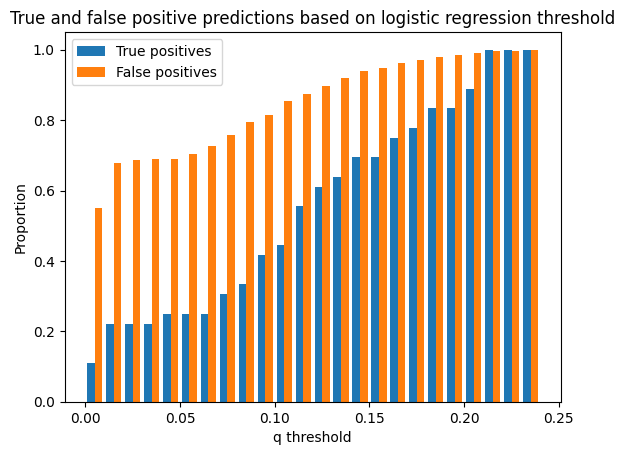

In [169]:
# how we choose q
import matplotlib.pyplot as plt

y_true = y_predp[y_test == 1][:, 1]
y_false = y_predp[y_test == 0][:, 1]
plt.hist([y_true, y_false], density = True, bins = [n/100 for n in range(25)], cumulative = True, label=["True positives", "False positives"])
plt.legend()
plt.xlabel("q threshold")
plt.ylabel("Proportion")
plt.title("True and false positive predictions based on logistic regression threshold")
plt.show()

In [170]:
# plotting precision vs recall tradeoff

# Create x and y arrays
precision = [i[1] for i in models_stats.values()]
accuracy = [i[2] for i in models_stats.values()]

# Create labels array
labels = [round(v[3], 2) for v in models_stats.values()]

fig = px.scatter(x=precision, y=accuracy, title = 'recall vs. precision of models before filtering', text = labels)
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_title='Precision', yaxis_title="Recall", title='Recall vs Precision for our 37 models')
fig.show()

In [171]:
# Show the classification metrics over each q threshold
F = []
B = []
R = []
P = []
for q in np.linspace(.01,.3,30):
    y_pred = (y_predp > q).astype(int)[:,1]
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f0 = f1_score([1-y for y in y_test],[1-y for y in y_pred], zero_division=0)
    w1 = sum(y_test)/y_test.size
    w0 = 1 - w1
    b = f1*w1 + f0*w0
    r = recall_score(y_test, y_pred, zero_division=0)
    p = precision_score(y_test, y_pred, zero_division=0)
    F.append(f1)
    B.append(b)
    R.append(r)
    P.append(p)

df = pd.DataFrame({'q': np.linspace(.01,.3,30).tolist(), 'F1_score': F, 'Balanced F1 Score': B, 'Recall': R, 'Precision': P})
fig = px.scatter(df, x = 'q', y = ['F1_score', 'Balanced F1 Score', 'Recall', 'Precision'], title = 'Classification Success vs. Q Threshold')
fig.update_traces(mode='markers+lines')
fig.show()

From the `Classification Success vs. Q Threshold` plot, we see that $q=0.7$ performs best. It has good recall before the recall curve declines, and the precision is reasonable. At $q=0.7$, the F1 score is close to 0.2, and the balanced F1-score is 0.8.

Why do we care about the balanced F1 socre? F1 score can be biased towards the majority class, whereas the weighted F1 score takes into account the class imbalance and gives equal importance to all classes. Therefore, the weighted F1 score is can be a more appropriate measure of performance in such scenarios.

How does our model do when we select $q = 0.7$ as our threshold for logistic regression predictions?

In [172]:
q= .07 # tune by hand
y_pred = (y_predp > q).astype(int)[:,1]

print(q)
print('Testing:')
print('Accuracy:', accuracy_score(y_test, y_pred))
p = precision_score(y_test, y_pred)
print('Precision:', p)
r = recall_score(y_test, y_pred)
print('Recall:', r)
print('F1 score:', f1_score(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

0.07
Testing:
Accuracy: 0.7272727272727273
Precision: 0.109375
Recall: 0.7567567567567568
F1 score: 0.1911262798634812
Confusion matrix:
 [[604 228]
 [  9  28]]


## Validation
Our last step is to test our model on validation data that we have never touched before. We are hoping for a high balanced f1-score (.70-.90)

In [174]:
# Ensemble validation

# Create an empty array to store the predictions of each model
validate_predictions = np.empty((X_validate.shape[0], len(models)))

# Make predictions for each model and store them in the predictions array
for i, model in enumerate(models):
    validate_predictions[:, i] = model.predict(X_validate).flatten()
y_predp = ensemble_model.predict_proba(validate_predictions)
y_pred = (y_predp > q).astype(int)[:,1]

print('Validating:')
print('Accuracy:', accuracy_score(y_validate, y_pred))
p = precision_score(y_validate, y_pred)
print('Precision:', p)
r = recall_score(y_validate, y_pred)
print('Recall:', r)
print('F1 score:', f1_score(y_validate, y_pred))
f1 = f1_score(y_validate, y_pred)
f0 = f1_score([1-y for y in y_validate],[1-y for y in y_pred])
w1 = sum(y_validate)/y_validate.size
w0 = 1 - w1
balanced_f1 = f1*w1 + f0*w0
print('Balanced F1 score:', balanced_f1)
cm = metrics.confusion_matrix(y_validate, y_pred)
print('Confusion matrix:\n', cm)

24/24 [==============================] - 0s 6ms/step
Validating:
Accuracy: 0.7301173402868318
Precision: 0.1581196581196581
Recall: 0.7872340425531915
F1 score: 0.26334519572953735
Balanced F1 score: 0.7997792644945046
Confusion matrix:
 [[523 197]
 [ 10  37]]


And we also validate the components of the ensemble model to further inform us why/when our model performs well.

In [176]:
# individual model validation because why not?

for i, model in enumerate(models):
    
    ### comment this out to validate individual models ###
    #break ### comment this out to validate individual models ###
    ### comment this out to validate individual models ###

    y_pred_prob = model.predict(X_validate)
    y_pred_test_prob = model.predict(X_test)

    # Apply threshold to get predicted classes
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_pred_test = (y_pred_test_prob > 0.5).astype(int)
    print('model #:', i)
    print('Accuracy:', accuracy_score(y_validate, y_pred))
    p = precision_score(y_validate, y_pred)
    print('Precision:', p)
    r = recall_score(y_validate, y_pred)
    print('Recall:', r)
    print('F1 score:', f1_score(y_validate, y_pred))
    cm = metrics.confusion_matrix(y_validate, y_pred)
    print('Confusion matrix:\n', cm)

28/28 [==============================] - 0s 4ms/step
model #: 0
Accuracy: 0.7092568448500652
Precision: 0.13636363636363635
Recall: 0.7021276595744681
F1 score: 0.22837370242214533
Confusion matrix:
 [[511 209]
 [ 14  33]]
28/28 [==============================] - 0s 5ms/step
model #: 1
Accuracy: 0.8305084745762712
Precision: 0.18796992481203006
Recall: 0.5319148936170213
F1 score: 0.27777777777777773
Confusion matrix:
 [[612 108]
 [ 22  25]]
28/28 [==============================] - 0s 4ms/step
model #: 2
Accuracy: 0.7653194263363755
Precision: 0.1518324607329843
Recall: 0.6170212765957447
F1 score: 0.24369747899159663
Confusion matrix:
 [[558 162]
 [ 18  29]]
28/28 [==============================] - 0s 3ms/step
model #: 3
Accuracy: 0.7405475880052151
Precision: 0.14814814814814814
Recall: 0.6808510638297872
F1 score: 0.24334600760456274
Confusion matrix:
 [[536 184]
 [ 15  32]]
28/28 [==============================] - 0s 2ms/step
model #: 4
Accuracy: 0.7770534550195567
Precision: 0.170

##Observations and Future Work
There were some observations we had that we would have liked to demonstrate here, if we had more time. Specifically, oversampling via SMOTE was highly effective. We also tried oversampling via ADASYN, which had little difference compared to SMOTE. When we did not oversample, we encountered numerous issues: models would either predict all patients to have strokes, or predict no patients to have strokes.

We added Framington Risk Factor as a predictive feature, which increased the model performance substantially. The model F1 scores generally increased by about 0.06 after we added Framington Risk Factor.

We also considered using a neural network to conglomerate all our component models into an ensemble instead of using a logistic regression.

Finally for future work, we would like to do one thing we weren't allowed to do in this exercise: review the literature and build off established techniques. Of course, without this step, the exercise is much more valuable, but it would be an interesting next step.

In conclusion, we made an ensemble model of neural networks and random forests on augmented healthcare data in order to predict strokes with a balanced F1-score of ~80.0 on our validation data.